<a href="https://colab.research.google.com/github/IC-UFAL-IADD/IADD/blob/codebasics/CNN_Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#################################################
### **Created by Marcelo Oliveira on 06/2021.**
### **Disciplina de Fundamentos de IA aplicados ao Diagnóstico de Doenças (IADD).**
### **Copyright (c)2021 Instituto de Computação**
### **Universidade Federal de Alagoas - UFAL. All rights reserved.**
#################################################

References:


*   https://www.kaggle.com/avirdee/siim-covid-19-initial-pipeline-fastai/notebook



In [ ]:
#!pip install git+https://github.com/fastai/fastai.git
!pip install fastai --upgrade -q

In [ ]:
!pip install python-gdcm pydicom

     |████████████████████████████████| 9.4 MB 7.2 MB/s 
     |████████████████████████████████| 2.0 MB 57.6 MB/s 


In [ ]:
!pip install kornia

     |████████████████████████████████| 309 kB 8.2 MB/s 


In [ ]:
!pip install scikit-image

In [ ]:
import fastai; print(fastai.__version__)
import fastcore; print(fastcore.__version__)
import pydicom,kornia,skimage


2.5.2
1.3.26


In [ ]:
from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *
from fastai.medical.imaging import *

In [ ]:
!touch "/content/drive/My Drive/ping.txt"
source=Path("/content/drive/My Drive/DataSets/Classificacao_COVID_NORMAL/")
files = os.listdir(source)
print(files)

['COVID', 'normal', '_covid_normal.csv', 'covid_normal.csv']


Load in the csv file

In [ ]:
df = pd.read_csv(source/'covid_normal.csv')
df.head()

,Unnamed: 0,files,target
0,0,normal/0023f02ae886.dcm,normal
1,1,normal/00e3a7e91a34.dcm,normal
2,2,normal/010214f9b600.dcm,normal
3,3,normal/010433f32857.dcm,normal
4,4,normal/0124f624dacb.dcm,normal


In [ ]:
class FixMonochrome(PILDicom):
    @classmethod
    def create(cls, fn:(Path, str, bytes), fix_monochrome = True)->None:
        if isinstance(fn, bytes): im = pydicom.dcmread(pydicom.filebase.DicomBytesIO(fn))
        if isinstance(fn, (Path, str)): im = pydicom.dcmread(fn)
        scaled = np.array(im.pixel_array)   
        if fix_monochrome and im.PhotometricInterpretation == "MONOCHROME1":
            scaled = np.amax(scaled) - scaled
        scaled = scaled - np.min(scaled)
        scaled = scaled / np.max(scaled)
        scaled = (scaled * 255).astype(np.uint8)
        pill_im = Image.fromarray(scaled)
        return cls(pill_im)

In [ ]:
#blocks = (ImageBlock(cls=PILDicom), CategoryBlock)
blocks = (ImageBlock(cls=FixMonochrome), CategoryBlock)


In [ ]:
data_block = DataBlock(blocks=blocks,
                       getters = [ColReader('files', pref=source, suff=''), ColReader('target')],
                       item_tfms = [Resize(224, 224)],
                       splitter  = RandomSplitter(valid_pct=0.2, seed=42)
                      )

dls = data_block.dataloaders(df, bs=16, num_workers=0)  #bs (batch size), workers(processos na RAM, maior o bs maior o workers)
#dls.vocab
dls.one_batch()

In [ ]:
learn = cnn_learner(dls, 
                    resnet34, 
                    metrics=[accuracy, error_rate]) 

In [ ]:
learn.fine_tune(4)

# Print do Resultado com a RESNET34

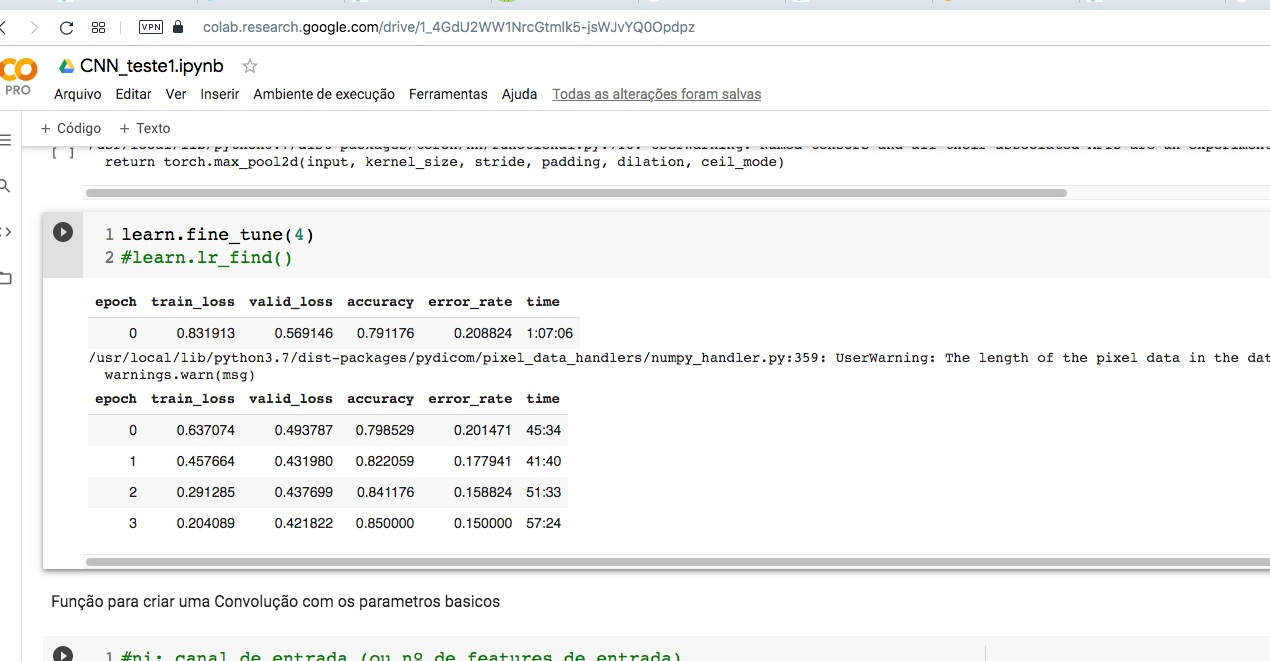

Função para criar uma Convolução com os parametros basicos

In [ ]:
#ni: canal de entrada (ou nº de features de entrada)
#nf: features de saída
def conv(ni, nf, ks=3, act=True):
  res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
  
  #Se True adiciona Relu(Tanh) e MaxPooling
  if act: res = nn.Sequential(res,                
                              nn.ReLU(),
                              nn.MaxPool2d(2)) 
                              #após cada Pooling é aplicado uma Fully Connected
  return res 

In [ ]:
simple_cnn = sequential(
    conv(1, 32), 
    conv(32, 64), 
    conv(64,128), 
    conv(128,256),
    conv(256,2, act=False), #1x1
    Flatten(),
)

In [ ]:
xb, yb = first(dls.valid) 

In [ ]:
xb.shape

torch.Size([16, 1, 224, 224])

In [ ]:
# No método Learner o Dropout é ativado automaticamente

In [ ]:
learn = Learner(
    dls, 
    simple_cnn, 
    loss_func=F.cross_entropy, #funcao para minimizar o erro
    metrics=[accuracy, error_rate])

In [ ]:
learn.model.cuda()

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (4): Conv2d(256, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Flatten(full=False)
)

In [ ]:
learn.summary()

Sequential (Input shape: 16)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 32 x 112 x 112 
Conv2d                                    320        True      
ReLU                                                           
MaxPool2d                                                      
____________________________________________________________________________
                     16 x 64 x 28 x 28   
Conv2d                                    18496      True      
ReLU                                                           
MaxPool2d                                                      
____________________________________________________________________________
                     16 x 128 x 7 x 7    
Conv2d                                    73856      True      
ReLU                                                           
MaxPool2d                                                      
___________________________________________________

In [ ]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.694736,0.694837,0.498529,0.501471,51:08
1,0.693831,0.694065,0.498529,0.501471,54:14
2,0.693238,0.693773,0.498529,0.501471,54:08
3,0.692764,0.693770,0.498529,0.501471,54:22


/usr/local/lib/python3.7/dist-packages/pydicom/pixel_data_handlers/numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


**Salve o 1 estágio do Modelo para não precisar Retreiná-lo do zero. Todas as camadas exceto a última estão "congeladas"**

In [ ]:
# Save the model
learn.save('stage-1')

Path('models/stage-1.pth')

In [ ]:
# Load the Model
learn.load('stage-1')

Podemos "descongelar" todas as camadas do modelo e retreiná-lo um pouco mais. Isto irá alterar como o modelo avalia a imagem e não somente como ele a classifica. Antes do treinamento, vamos encontrar a melhro taxa de treinamento e apresentá-la num gráfico.

/usr/local/lib/python3.7/dist-packages/pydicom/pixel_data_handlers/numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


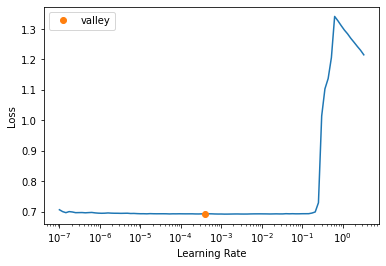

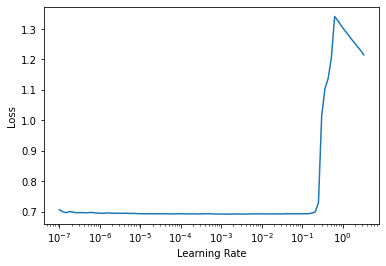

In [ ]:
# Unfreeze all layers of the CNN
learn.unfreeze()
# Find the optimal learning rate and plot a visual
learn.lr_find()
learn.recorder.plot_lr_find()

In [ ]:
# Fit the model over 2 epochs
learn.fit_one_cycle(2, lr_max=slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.693737,0.693368,0.498529,0.501471,1:16:30
1,0.692846,0.693548,0.498529,0.501471,1:07:46


/usr/local/lib/python3.7/dist-packages/pydicom/pixel_data_handlers/numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)
